<a href="https://colab.research.google.com/github/wander-asb/MRI_CLASSIFICATION/blob/main/A_new_deep_CNN_for_Brain_tumor_classification(Binary).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bibliotecas:


In [1]:
import torch
import os
import shutil
import pandas              as pd
import numpy               as np
import torch.nn.functional as F
import cv2                 as cv 
import matplotlib.pyplot   as plt
import seaborn             as sns


from PIL                     import Image
from skimage                 import io
from google.colab            import drive
from google.colab.patches    import cv2_imshow
from torch                   import nn, optim
from torchvision             import datasets, transforms, models
from sklearn.model_selection import train_test_split

## Leitura da base de dados

In [2]:
#Conectamos com o drive que possui nosso conjunto de dados
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Leitura do path de dados de treino e teste
path_teste = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/BinaryTumor/Testing'
path_treino = '/content/gdrive/MyDrive/MRI_TUMOR_CNN/BinaryTumor/Treinimg'

In [4]:
transform_train = transforms.Compose(
    [
     transforms.Resize([128,128]),
     transforms.ToTensor()
    ]
)

transform_test = transforms.Compose(
    [
     transforms.Resize([128,128]),
     transforms.ToTensor()  
    ]
)

In [5]:
train_dataset = datasets.ImageFolder(path_treino, transform=transform_train)
test_dataset = datasets.ImageFolder(path_teste, transform=transform_test)

## Visão geral do conjunto de dados

In [6]:
classes = test_dataset.class_to_idx
print(classes)

out = len(classes)
print("Numéro de saídas {}".format(out))

{'no_tumor': 0, 'yes_tumor': 1}
Numéro de saídas 2


In [7]:
idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}

def get_class_distribution(dataset_obj):
  count_dict = {k:0 for k, v in dataset_obj.class_to_idx.items()}
  for i in dataset_obj:
    y_labels = i[1]
    y_labels = idx2class[y_labels]
    count_dict[y_labels] += 1
  return count_dict

Text(0.5, 1.0, 'Distribuição de Imagens de ressonâncias magnéticas')

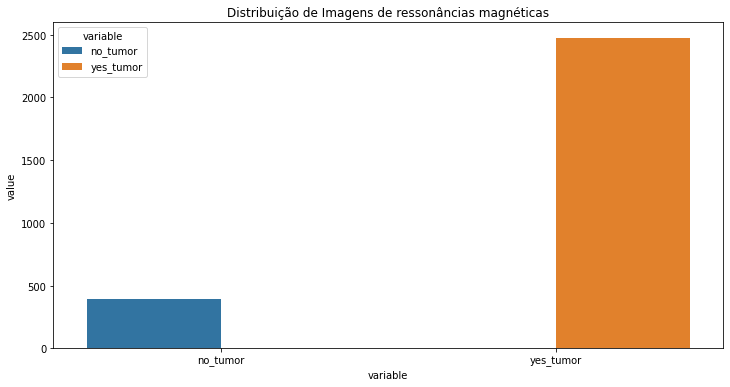

In [8]:
plt.figure(figsize=(12,6))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_dataset)])\
            .melt(), x = "variable", y="value", hue="variable")\
            .set_title('Distribuição de Imagens de ressonâncias magnéticas')

In [9]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True)

In [10]:
for batch in train_loader:
  dado, rotulo = batch
  print(dado.size(), rotulo.size())
  break

torch.Size([12, 3, 128, 128]) torch.Size([12])


Na célula acima, podemos visualizar que nosso conjunto de dados apresenta imagens divididas em 12 rótulos, com 3 camadas de cores(rgb) e de dimensões 128x128.

## Arquitetura CNN

In [22]:
class classificador(nn.Module):
    def __init__ (self):
        super().__init__()
      
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=(1,1))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=(1,1))

        self.activation = nn.ReLU() 
        self.bnorm1 = nn.BatchNorm2d(num_features=16)
        self.bnorm2 = nn.BatchNorm2d(num_features=64)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        
        self.flatten = nn.Flatten()
        self.sig = nn.Sigmoid()
        

        self.linear1 = nn.Linear(in_features=57600, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=128)
        self.linear3 = nn.Linear(in_features=128, out_features=out)
        
    def forward(self, X):
        X = self.pool(self.bnorm1(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm2(self.activation(self.conv2(X))))
        X = self.flatten(X)
        
        X = self.activation(self.linear1(X))
        X = self.activation(self.linear2(X))
        X = self.linear3(X)
        X = self.sig()
        
        return X

In [23]:
net =  classificador()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [25]:
net.to(device)

classificador(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sig): Sigmoid()
  (linear1): Linear(in_features=57600, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=2, bias=True)
)

In [26]:
loss_values = []
accu_values = []
def training_binary_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        
        inputs, labels = data
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = criterion(outputs, labels.float().view(*outputs.shape))
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        predicted = torch.tensor([1 if output > 0.5 else 0 for output in outputs]).to(device)
        
        equals = predicted == labels.view(*predicted.shape)
        
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy


        #Imprimir os dados referentes a este loop
        print("Época {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}".format(epoch + 1, i+1, len(loader)\
                                                                                             , loss, accuracy), end= '\r')
    #Impressão referente à épocas
    print("Época {:3d} Finalizada: perda {:.5f} - precisão {:.5f}".format(epoch+1, running_loss/len(loader)\
                                                                         ,running_accuracy/len(loader)))
    loss_values.append(running_loss / len(loader))
    accu_values.append(running_accuracy/len(loader))

In [27]:
loss_train = [item for item in loss_values]
accu_train = [item for item in accu_values]

In [30]:
for epoch in range(20):
    print("Treinando...")
    training_binary_loop(train_loader, epoch)
    net.eval()
    net.train()

Treinando...


TypeError: ignored

In [29]:
loss_train = [item for item in loss_values]
accu_train = [item for item in accu_values]

In [ ]:
accu_values.clear()
loss_values.clear()
for epoch in range(20):
    net.eval()
    print("Validando...")
    training_binary_loop(test_loader, epoch)
    net.train()

In [ ]:
loss_test = [item for item in loss_values]
accu_test = [item for item in accu_values]

In [ ]:
epochs_x = range(1, len(loss_test) + 1)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(epochs_x, loss_train, 'bo', label='Training loss')
plt.plot(epochs_x, loss_test, 'b', label='Testing loss')
plt.title('Training and Testing Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.legend()
plt.subplot(2,1,2)
#val_acc_values = history_dict['val_accuracy']
plt.plot(epochs_x, accu_train, 'bo', label='Training acc')
plt.plot(epochs_x, accu_test, 'b', label='Testing acc')
#plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()